## Pre-requisite

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/Zero/Zero"

/content/drive/MyDrive/Zero/Zero


## Code

In [ ]:
import os

import scipy

import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.lines import Line2D

import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR


In [ ]:
data_unprocess_agg_df_berttopics_lda_pivot_normal = pd.read_csv("PPT/data_unprocess_agg_df_berttopics_lda_pivot_normal.csv")
data_unprocess_agg_df_berttopics_lda_pivot_normal["0"] = pd.to_datetime(data_unprocess_agg_df_berttopics_lda_pivot_normal["0"])
data_unprocess_agg_df_berttopics_lda_pivot_normal_week = data_unprocess_agg_df_berttopics_lda_pivot_normal.groupby(pd.Grouper(key="0", freq='W')).mean()

data_all_topics_label = pd.read_csv("PPT/data_all_topics_label.csv")
labels = set(data_all_topics_label["label"])

label_topic_dict = dict()
for label in labels:
  label_topic_dict[label] = list(data_all_topics_label.index[data_all_topics_label["label"] == label])

df_label = pd.DataFrame(0, index=data_unprocess_agg_df_berttopics_lda_pivot_normal_week.index, columns=label_topic_dict.keys())
for label, label_list  in label_topic_dict.items():
  df_label[label] = data_unprocess_agg_df_berttopics_lda_pivot_normal_week.iloc[:, label_topic_dict[label]].mean(axis=1)

df_label = df_label.rename({"教育": "education", "无关": "irrelevant", "政治":"politics", "艺术":"art", "宗教":"religion", "灾害": "disaster", "科技": "technology",
                            "自然": "nature", "医疗": "medical", "污染": "pollution", "社会": "society", "经济": "economy", "能源": "energy", "Geoengineering": "geoengineering"}, axis=1)
df_label = df_label[[i for i in df_label.columns if i != "irrelevant"]]

df_gts = []
for term in os.listdir("PPT/googletrends"):
  df_gts.append(pd.read_csv("PPT/googletrends/" + term, index_col=0))
df_gts = pd.concat(df_gts, axis=1)
df_gts.index = pd.to_datetime(df_gts.index)

df_timeseries = pd.concat([df_label[["disaster", "energy", "nature", "politics", "religion"]], df_gts.mean(axis=1).rename("Geoengineering Index")], axis=1)


In [ ]:
df_all_sentiment_for_each_category = pd.read_csv("df_all_sentiment_for_each_category.csv", index_col=0)
df_all_sentiment_for_each_category = (df_all_sentiment_for_each_category - df_all_sentiment_for_each_category.min()) / (df_all_sentiment_for_each_category.max() - df_all_sentiment_for_each_category.min())

In [ ]:
dftest = adfuller(df_timeseries["Geoengineering Index"], autolag = 'AIC')
print("ADF : ",dftest[0])
print("P-Value : ", dftest[1])

ADF :  -2.6535037993506463
P-Value :  0.0824354590494979


## Autoregression

In [ ]:
mod_ar = AutoReg(df_timeseries["Geoengineering Index"], 4, old_names=False)
res_ar = mod_ar.fit()
print(res_ar.summary())

                             AutoReg Model Results                              
Dep. Variable:     Geoengineering Index   No. Observations:                  261
Model:                       AutoReg(4)   Log Likelihood                 194.199
Method:                 Conditional MLE   S.D. of innovations              0.114
Date:                  Sun, 24 Mar 2024   AIC                           -376.398
Time:                          00:02:55   BIC                           -355.104
Sample:                      02-04-2018   HQIC                          -367.835
                           - 01-01-2023                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0432      0.017      2.532      0.011       0.010       0.077
Geoengineering Index.L1     0.4765      0.061      7.789      0.000       0.

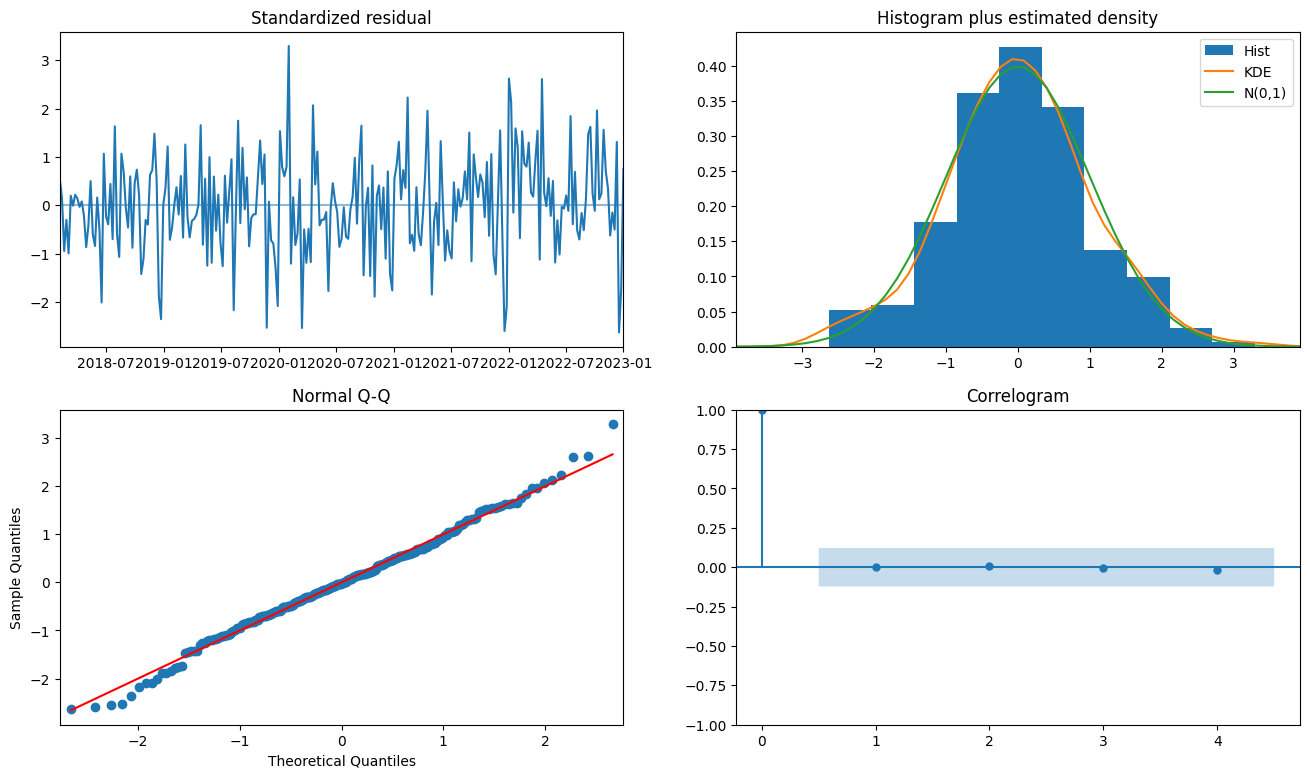

In [ ]:
fig = plt.figure(figsize=(16, 9))
fig = res_ar.plot_diagnostics(fig=fig, lags=4)

## Autoregression with Exogenous

In [ ]:
mod_are = AutoReg(df_timeseries["Geoengineering Index"], 4, old_names=False, exog=df_timeseries[["disaster", "energy", "nature", "politics", "religion"]])
res_are = mod_are.fit()
print(res_are.summary())

                             AutoReg Model Results                              
Dep. Variable:     Geoengineering Index   No. Observations:                  261
Model:                     AutoReg-X(4)   Log Likelihood                 202.355
Method:                 Conditional MLE   S.D. of innovations              0.110
Date:                  Sun, 24 Mar 2024   AIC                           -382.710
Time:                          00:02:56   BIC                           -343.670
Sample:                      02-04-2018   HQIC                          -367.010
                           - 01-01-2023                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.0145      0.038     -0.380      0.704      -0.089       0.060
Geoengineering Index.L1     0.4178      0.062      6.787      0.000       0.

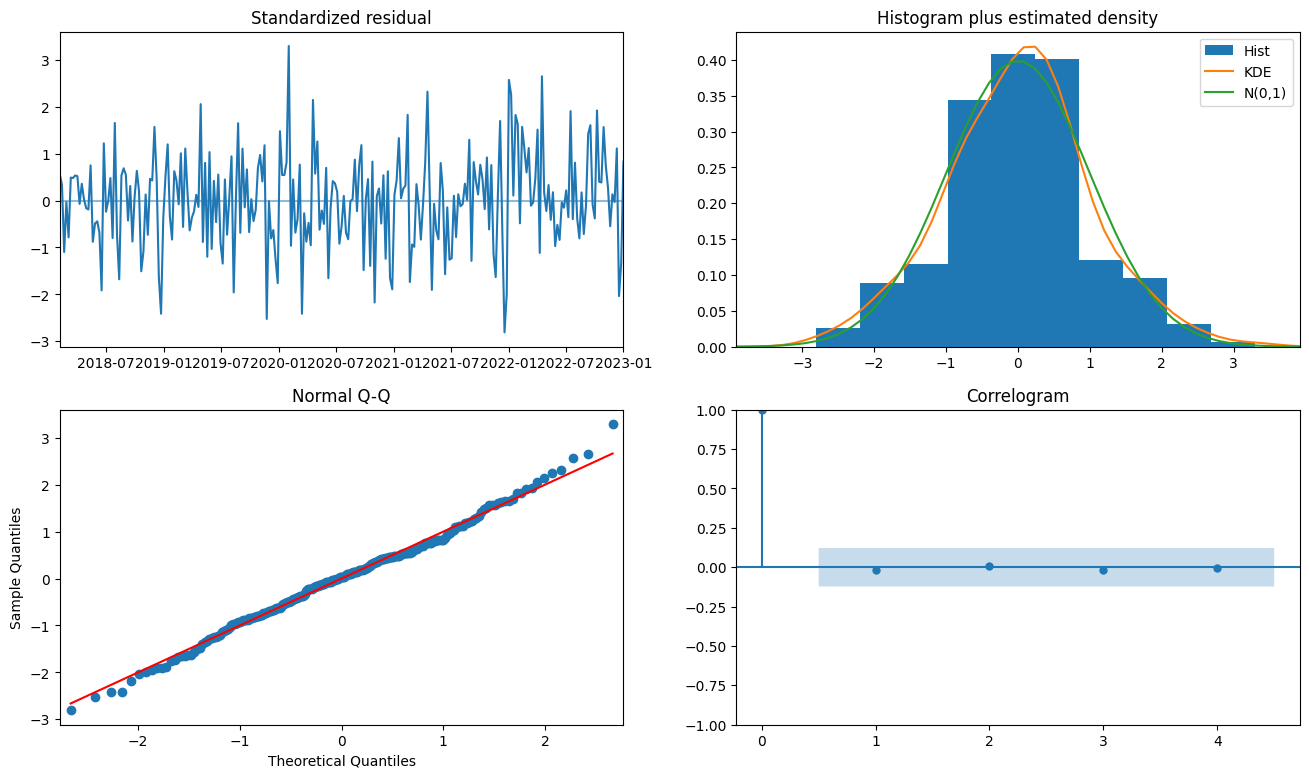

In [ ]:
fig = plt.figure(figsize=(16, 9))
fig = res_are.plot_diagnostics(fig=fig, lags=4)

In [ ]:
mod_are_sentiment = AutoReg(df_all_sentiment_for_each_category["Geoengineering Index"], 4, old_names=False, exog=df_all_sentiment_for_each_category[["disaster", "energy", "nature", "politics", "religion"]])
res_are_sentiment = mod_are_sentiment.fit()
print(res_are_sentiment.summary())

                             AutoReg Model Results                              
Dep. Variable:     Geoengineering Index   No. Observations:                  261
Model:                     AutoReg-X(4)   Log Likelihood                 199.731
Method:                 Conditional MLE   S.D. of innovations              0.111
Date:                  Mon, 25 Mar 2024   AIC                           -377.462
Time:                          20:01:04   BIC                           -338.422
Sample:                      02-04-2018   HQIC                          -361.762
                           - 01-01-2023                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0101      0.028      0.367      0.714      -0.044       0.064
Geoengineering Index.L1     0.4244      0.062      6.821      0.000       0.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


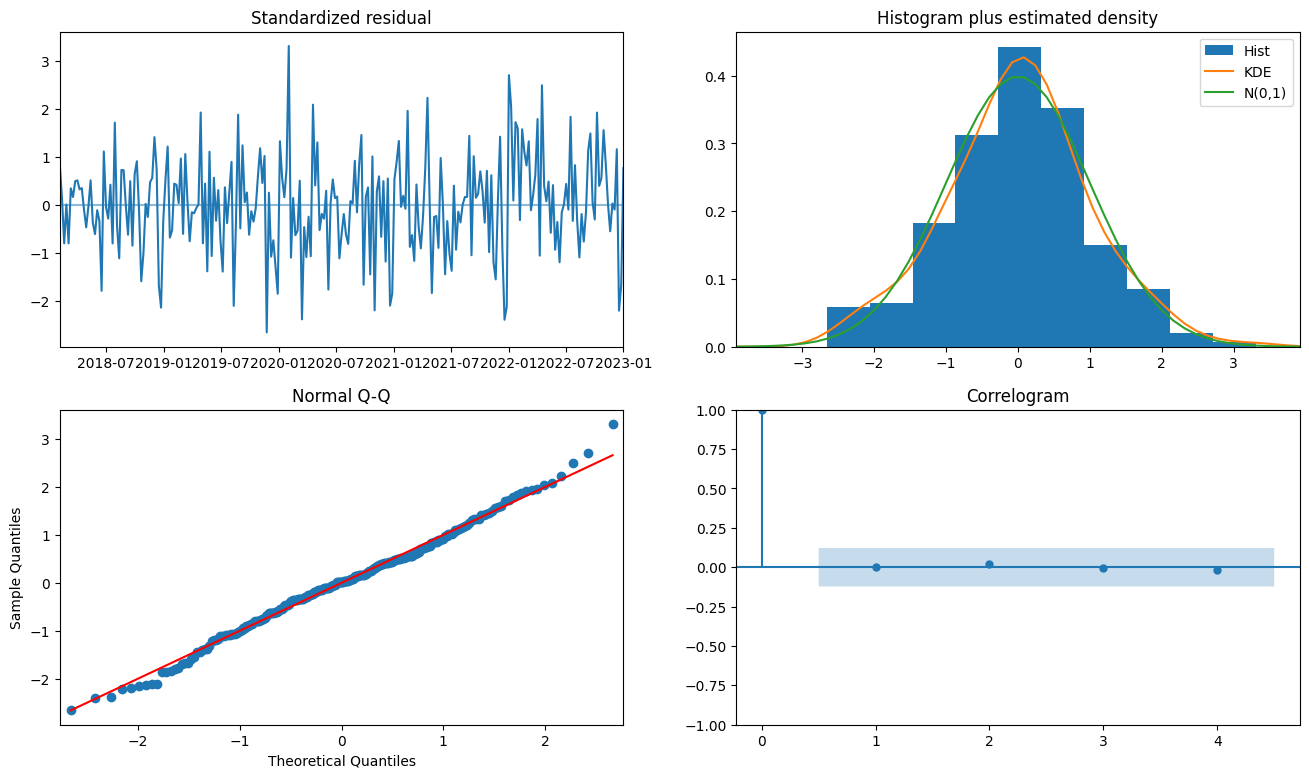

In [ ]:
fig = plt.figure(figsize=(16, 9))
fig = res_are_sentiment.plot_diagnostics(fig=fig, lags=4)

## ARIMA

In [ ]:
mod_arima = ARIMA(df_timeseries["Geoengineering Index"], order=(4,0,4))
res_arima = mod_arima.fit()
print(res_arima.summary())

                                SARIMAX Results                                 
Dep. Variable:     Geoengineering Index   No. Observations:                  261
Model:                   ARIMA(4, 0, 4)   Log Likelihood                 202.611
Date:                  Sun, 24 Mar 2024   AIC                           -385.222
Time:                          00:02:59   BIC                           -349.577
Sample:                      01-07-2018   HQIC                          -370.894
                           - 01-01-2023                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3834      0.067      5.722      0.000       0.252       0.515
ar.L1          0.0410      1.803      0.023      0.982      -3.493       3.575
ar.L2         -0.2112      1.075    

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


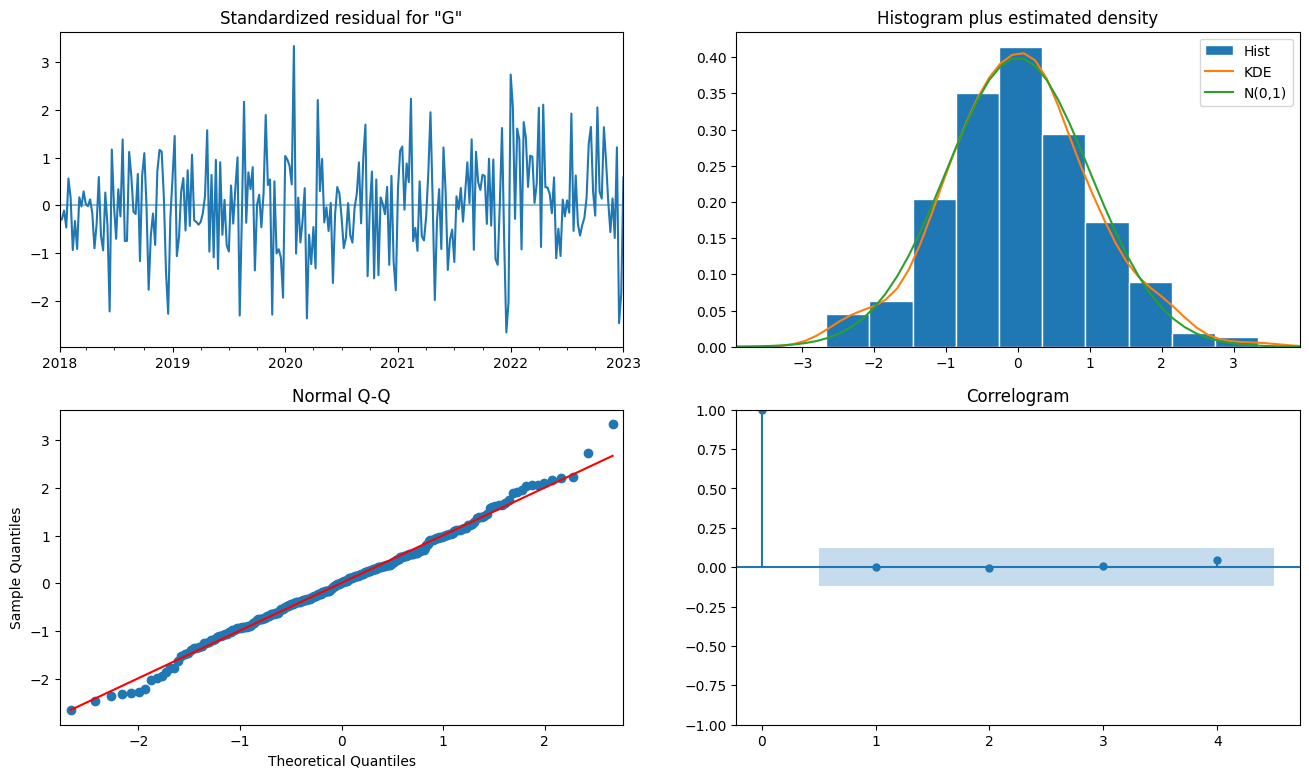

In [ ]:
fig = plt.figure(figsize=(16, 9))
fig = res_arima.plot_diagnostics(fig=fig, lags=4)

## ARIMA with Exogenous

In [ ]:
mod_arimae = ARIMA(df_timeseries["Geoengineering Index"], order=(4,0,4), exog=df_timeseries[["disaster", "energy", "nature", "politics", "religion"]])
res_arimae = mod_arimae.fit()
print(res_arimae.summary())

                                SARIMAX Results                                 
Dep. Variable:     Geoengineering Index   No. Observations:                  261
Model:                   ARIMA(4, 0, 4)   Log Likelihood                 208.255
Date:                  Sun, 24 Mar 2024   AIC                           -386.509
Time:                          00:03:02   BIC                           -333.041
Sample:                      01-07-2018   HQIC                          -365.017
                           - 01-01-2023                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3541      0.082      4.307      0.000       0.193       0.515
disaster       0.0277      0.056      0.496      0.620      -0.082       0.137
energy         0.1749      0.064    

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


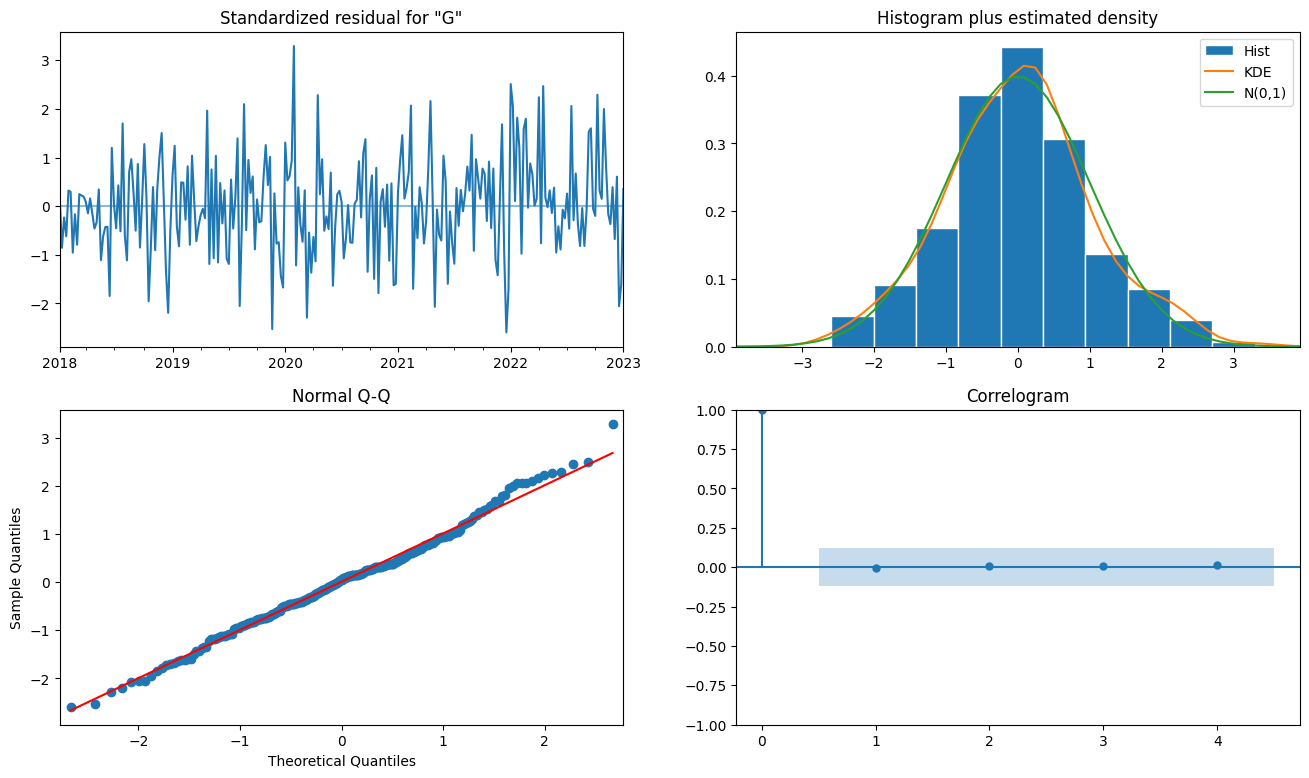

In [ ]:
fig = plt.figure(figsize=(16, 9))
fig = res_arimae.plot_diagnostics(fig=fig, lags=4)

In [ ]:
mod_arimae_sentiment = SARIMAX(df_all_sentiment_for_each_category["Geoengineering Index"], order=(4,0,4), seasonal_order=(0, 0, 0, 0), exog=df_all_sentiment_for_each_category[["disaster", "energy", "nature", "politics", "religion"]])
res_arimae_sentiment = mod_arimae_sentiment.fit(maxiter=1000)
print(res_arimae_sentiment.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


                                SARIMAX Results                                 
Dep. Variable:     Geoengineering Index   No. Observations:                  261
Model:                 SARIMAX(4, 0, 4)   Log Likelihood                 203.806
Date:                  Mon, 25 Mar 2024   AIC                           -379.612
Time:                          20:09:18   BIC                           -329.709
Sample:                      01-07-2018   HQIC                          -359.552
                           - 01-01-2023                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
disaster       0.0258      0.030      0.858      0.391      -0.033       0.085
energy         0.0940      0.040      2.338      0.019       0.015       0.173
nature        -0.0263      0.031    

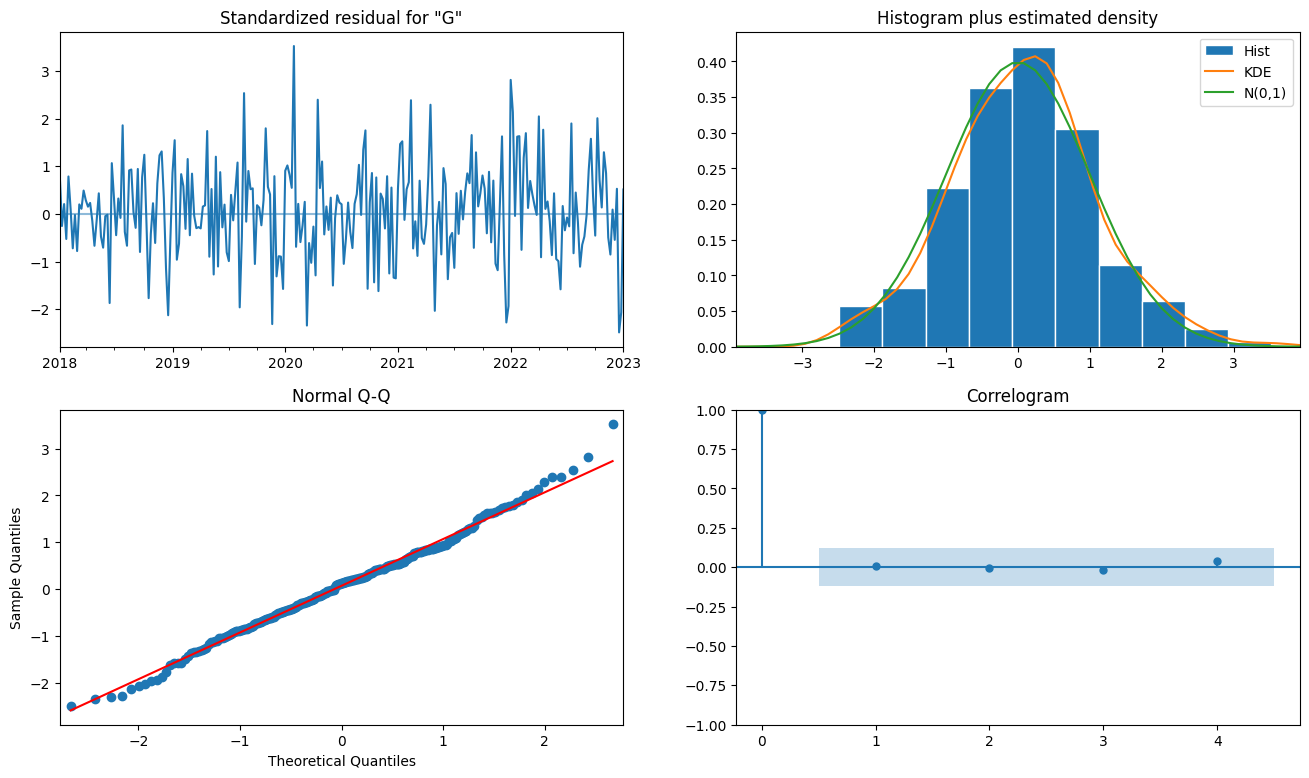

In [ ]:
fig = plt.figure(figsize=(16, 9))
fig = res_arimae_sentiment.plot_diagnostics(fig=fig, lags=4)

## SARIMA

In [ ]:
mod_sarimax = SARIMAX(df_timeseries["Geoengineering Index"], order=(4, 0, 4), seasonal_order=(1, 0, 1, 52))
res_sarimax = mod_sarimax.fit(maxiter=1000)
print(res_sarimax.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


                                      SARIMAX Results                                       
Dep. Variable:                 Geoengineering Index   No. Observations:                  261
Model:             SARIMAX(4, 0, 4)x(1, 0, [1], 52)   Log Likelihood                 212.764
Date:                              Sun, 24 Mar 2024   AIC                           -403.528
Time:                                      00:05:24   BIC                           -364.318
Sample:                                  01-07-2018   HQIC                          -387.766
                                       - 01-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1598      0.291     -0.548      0.583      -0.731       0.411
ar.L2         -0.08

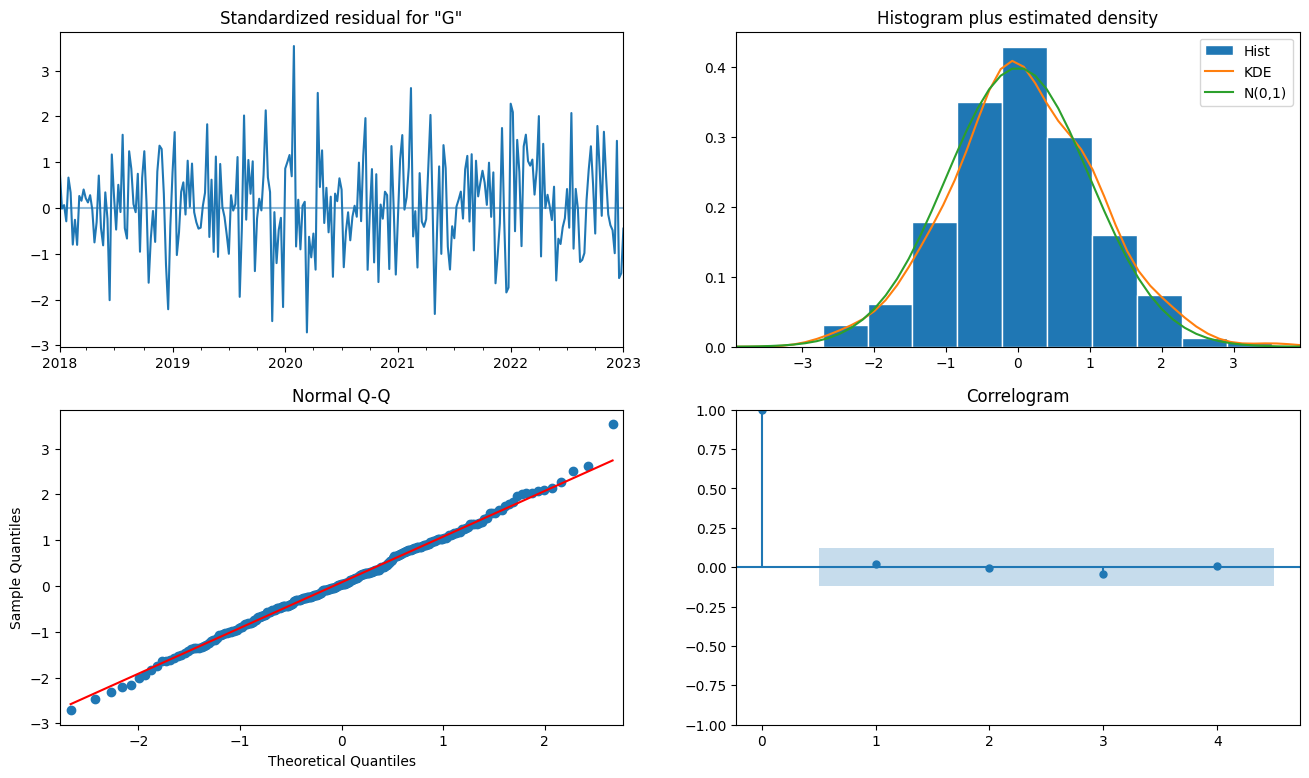

In [ ]:
fig = plt.figure(figsize=(16, 9))
fig = res_sarimax.plot_diagnostics(fig=fig, lags=4)

## SARIMA with Exogenous

In [ ]:
mod_sarimaxe = SARIMAX(df_timeseries["Geoengineering Index"], order=(4, 0, 4), seasonal_order=(1, 0, 1, 52), exog=df_timeseries[["disaster", "energy", "nature", "politics", "religion"]])
res_sarimaxe = mod_sarimaxe.fit(maxiter=1000)
print(res_sarimaxe.summary())

                                      SARIMAX Results                                       
Dep. Variable:                 Geoengineering Index   No. Observations:                  261
Model:             SARIMAX(4, 0, 4)x(1, 0, [1], 52)   Log Likelihood                 217.944
Date:                              Sun, 24 Mar 2024   AIC                           -403.888
Time:                                      00:09:36   BIC                           -346.856
Sample:                                  01-07-2018   HQIC                          -380.963
                                       - 01-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
disaster       0.0649      0.054      1.205      0.228      -0.041       0.170
energy         0.14

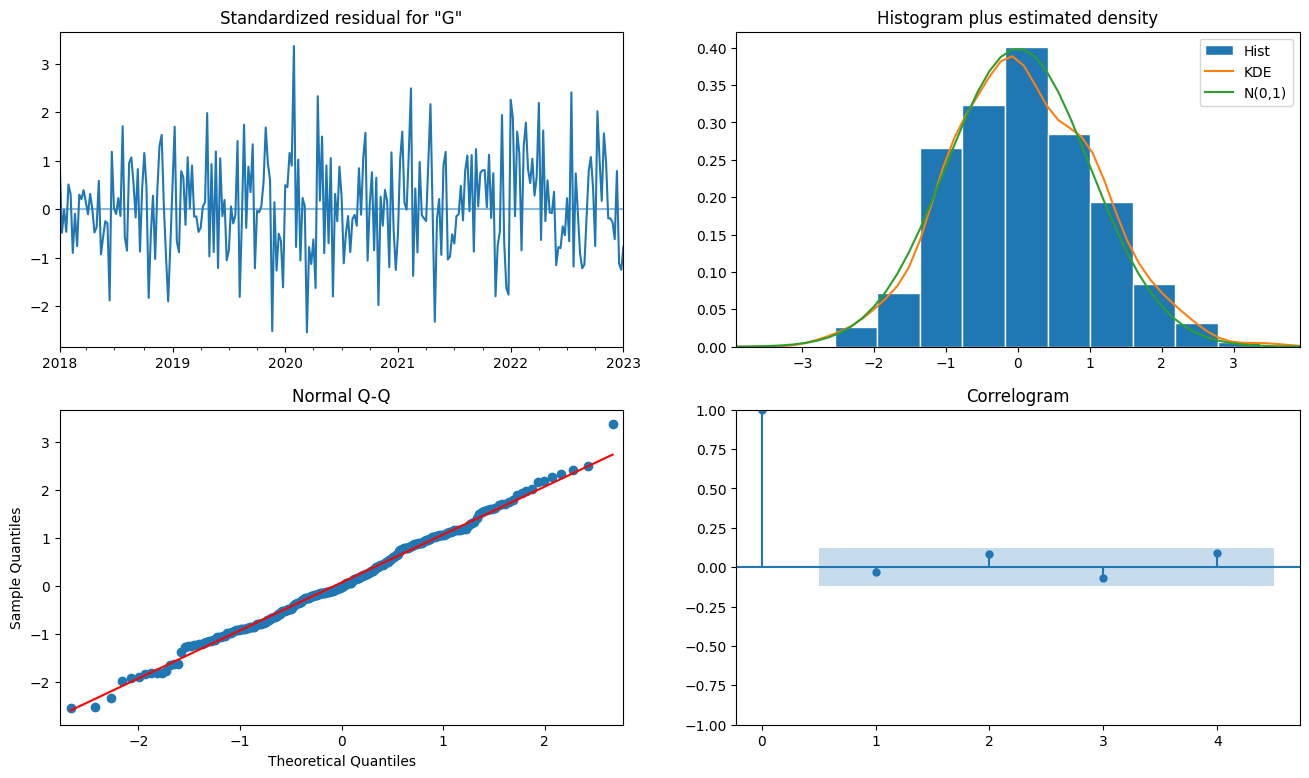

In [ ]:
fig = plt.figure(figsize=(16, 9))
fig = res_sarimaxe.plot_diagnostics(fig=fig, lags=4)

In [ ]:
mod_sarimaxe_sentiment = SARIMAX(df_all_sentiment_for_each_category["Geoengineering Index"], order=(4, 0, 4), seasonal_order=(1, 0, 1, 52), exog=df_all_sentiment_for_each_category[["disaster", "energy", "nature", "politics", "religion"]])
res_sarimaxe_sentiment = mod_sarimaxe_sentiment.fit(maxiter=1000)
print(res_sarimaxe_sentiment.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                 Geoengineering Index   No. Observations:                  261
Model:             SARIMAX(4, 0, 4)x(1, 0, [1], 52)   Log Likelihood                 216.543
Date:                              Mon, 25 Mar 2024   AIC                           -401.085
Time:                                      20:15:05   BIC                           -344.053
Sample:                                  01-07-2018   HQIC                          -378.160
                                       - 01-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
disaster       0.0282      0.036      0.790      0.430      -0.042       0.098
energy         0.07

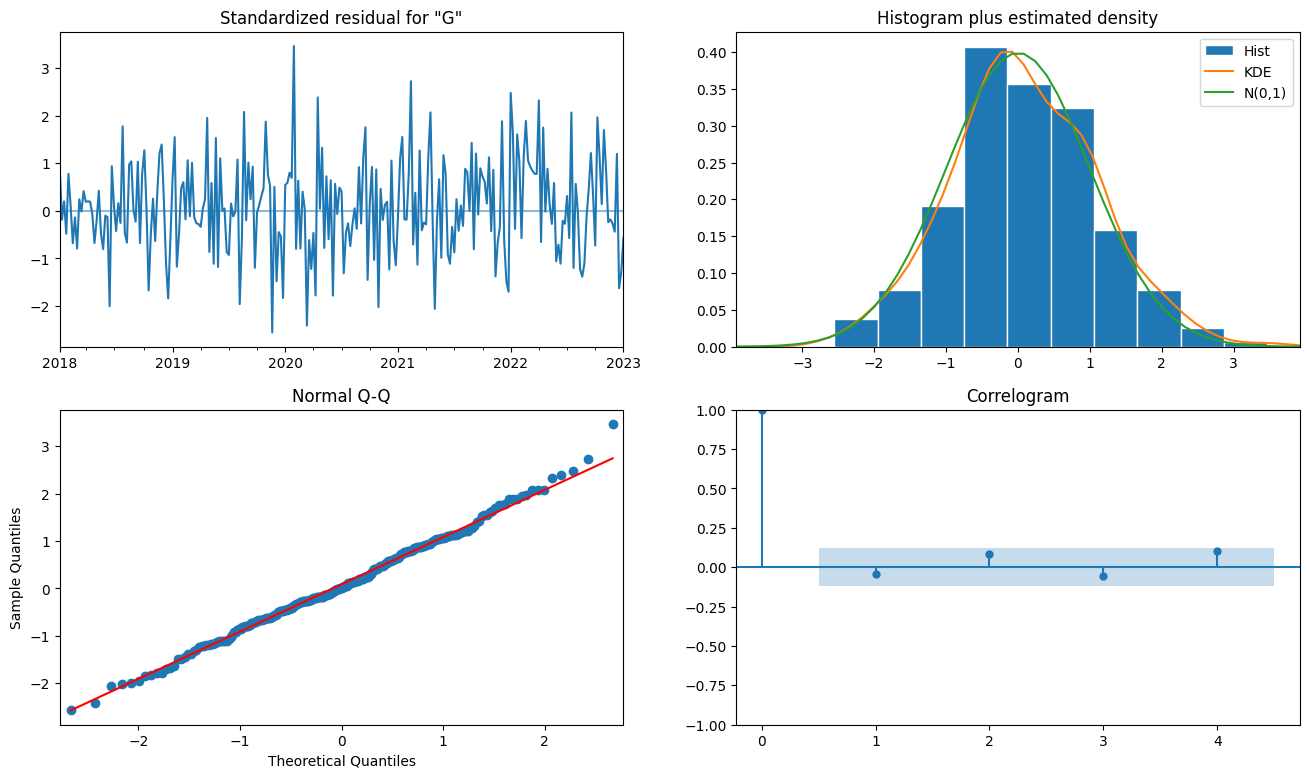

In [ ]:
fig = plt.figure(figsize=(16, 9))
fig = res_sarimaxe_sentiment.plot_diagnostics(fig=fig, lags=4)

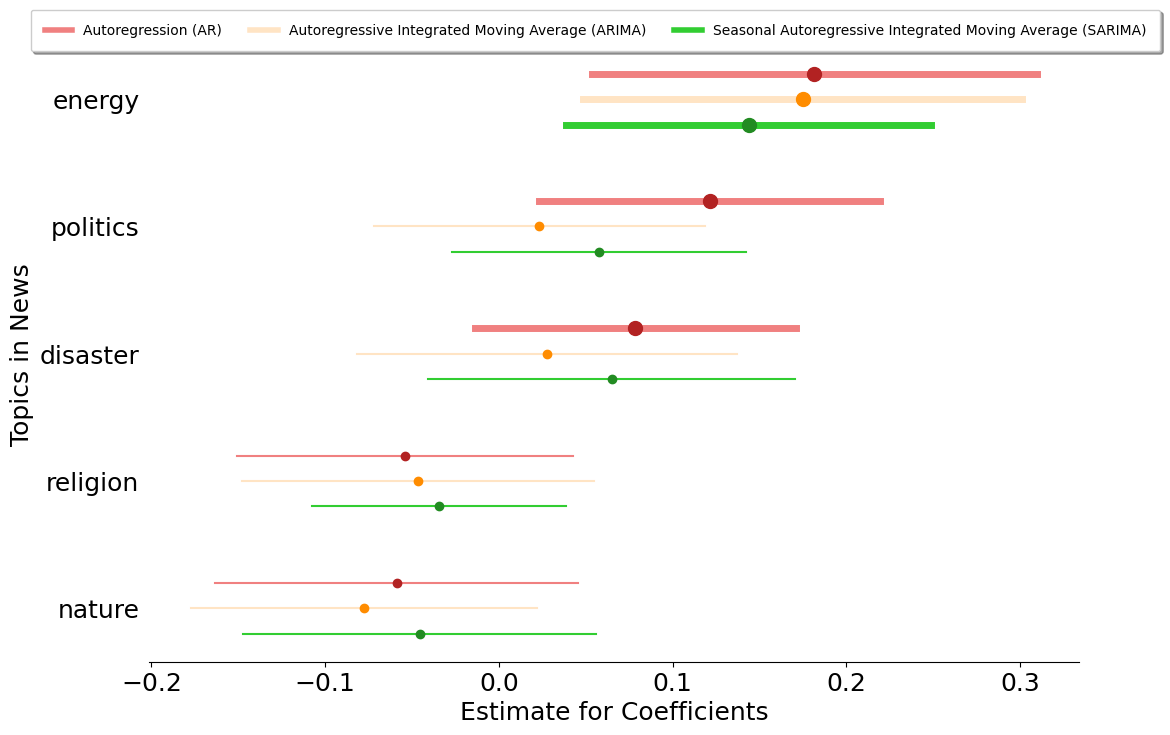

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
colors = {0: ["lightcoral", "firebrick"], 1: ["bisque", "darkorange"], 2: ["limegreen", "forestgreen"]}

for flag, res_e in enumerate([res_are, res_arimae, res_sarimaxe]):
  df_conf = res_e.conf_int()
  df_conf = df_conf.loc[sorted(df_timeseries.columns[:-1])].sort_values(0)
  for index, (flagg, row) in enumerate(df_conf.iterrows()):
    if res_e.pvalues[flagg] <= 0.1:
      ax.plot([row[0], row[1]], [index-flag*0.2, index-flag*0.2], color=colors[flag][0], linewidth=5)
      ax.plot((row[0] + row[1]) / 2, index-flag*0.2, 'o', color=colors[flag][1], markersize=10)
    else:
      ax.plot([row[0], row[1]], [index-flag*0.2, index-flag*0.2], color=colors[flag][0])
      ax.plot((row[0] + row[1]) / 2, index-flag*0.2, 'o', color=colors[flag][1])

ax.set_yticks([0-0.2, 1-0.2, 2-0.2, 3-0.2, 4-0.2])
ax.set_yticklabels(df_conf.index)

ax.tick_params(axis='y', which='major', labelsize=18)
ax.tick_params(axis='x', which='major', labelsize=18)
ax.tick_params(top=False, bottom=True, left=False, right=False, labelleft=True, labelbottom=True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_xlabel("Estimate for Coefficients", fontsize=18)
ax.set_ylabel("Topics in News", fontsize=18)

custom_lines = [Line2D([0], [0], color="lightcoral", lw=4),
                Line2D([0], [0], color="bisque", lw=4),
                Line2D([0], [0], color="limegreen", lw=4)]

ax.legend(custom_lines, ['Autoregression (AR)', 'Autoregressive Integrated Moving Average (ARIMA)',
                         'Seasonal Autoregressive Integrated Moving Average (SARIMA)'], fancybox=True, framealpha=1, shadow=True, borderpad=1, loc='upper center', ncol=3, bbox_to_anchor=(0.48, 1.07));

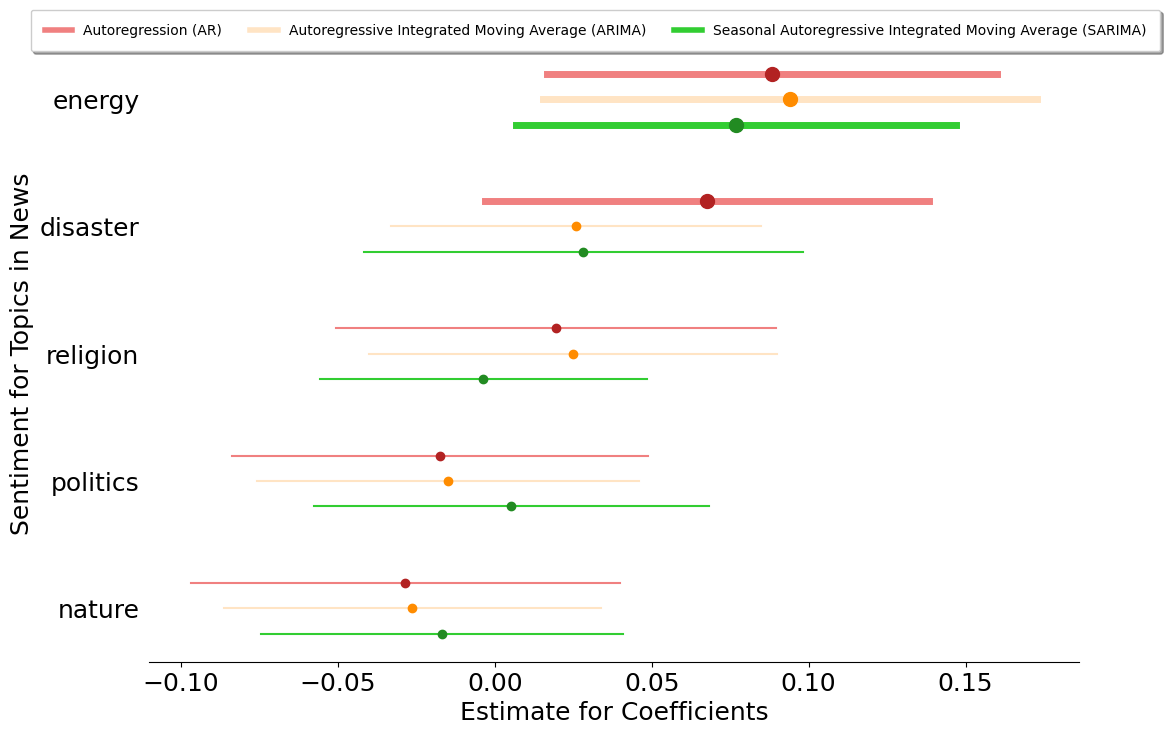

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
colors = {0: ["lightcoral", "firebrick"], 1: ["bisque", "darkorange"], 2: ["limegreen", "forestgreen"]}

for flag, res_e in enumerate([res_are_sentiment, res_arimae_sentiment, res_sarimaxe_sentiment]):
  df_conf = res_e.conf_int()
  df_conf = df_conf.loc[sorted(df_timeseries.columns[:-1])].sort_values(0)
  for index, (flagg, row) in enumerate(df_conf.iterrows()):
    if res_e.pvalues[flagg] <= 0.1:
      ax.plot([row[0], row[1]], [index-flag*0.2, index-flag*0.2], color=colors[flag][0], linewidth=5)
      ax.plot((row[0] + row[1]) / 2, index-flag*0.2, 'o', color=colors[flag][1], markersize=10)
    else:
      ax.plot([row[0], row[1]], [index-flag*0.2, index-flag*0.2], color=colors[flag][0])
      ax.plot((row[0] + row[1]) / 2, index-flag*0.2, 'o', color=colors[flag][1])

ax.set_yticks([0-0.2, 1-0.2, 2-0.2, 3-0.2, 4-0.2])
ax.set_yticklabels(df_conf.index)

ax.tick_params(axis='y', which='major', labelsize=18)
ax.tick_params(axis='x', which='major', labelsize=18)
ax.tick_params(top=False, bottom=True, left=False, right=False, labelleft=True, labelbottom=True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_xlabel("Estimate for Coefficients", fontsize=18)
ax.set_ylabel("Sentiment for Topics in News", fontsize=18)

custom_lines = [Line2D([0], [0], color="lightcoral", lw=4),
                Line2D([0], [0], color="bisque", lw=4),
                Line2D([0], [0], color="limegreen", lw=4)]

ax.legend(custom_lines, ['Autoregression (AR)', 'Autoregressive Integrated Moving Average (ARIMA)',
                         'Seasonal Autoregressive Integrated Moving Average (SARIMA)'], fancybox=True, framealpha=1, shadow=True, borderpad=1, loc='upper center', ncol=3, bbox_to_anchor=(0.48, 1.07));

## Vector Autogression

In [ ]:
# df_timeseries.to_csv("df_timeseries.csv")

In [ ]:
mod_var = VAR(df_timeseries)
res_var = mod_var.fit(10)

res_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 24, Mar, 2024
Time:                     00:09:37
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -18.0756
Nobs:                     251.000    HQIC:                  -21.1476
Log likelihood:           1142.73    FPE:                8.77282e-11
AIC:                     -23.2163    Det(Omega_mle):     2.37823e-11
--------------------------------------------------------------------
Results for equation disaster
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                           -0.073049         0.095268           -0.767           0.443
L1.disaster                      0.298970         0.088873            3.364           0.001
L1.energy    